In [51]:
!pip install opencv-python
!pip install scikit-plot

In [53]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [79]:
import numpy as np
import pandas as pd
import json 
import cv2

import glob
import os
import sys
import time
import pickle
import subprocess

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Rectangle

import imageio.v2
from PIL import Image

import shutil

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import NuSVC 

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from scikitplot.metrics import roc_curve
import scikitplot

from concurrent.futures import ThreadPoolExecutor

plt.style.use('ggplot')

In [14]:
PATH = 'kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json'
with open(PATH, 'r') as fp:
    data = json.load(fp)

df = pd.DataFrame.from_dict(data.keys())
print(len(df))

2346


In [15]:
def flatten_dict_columns(df, prefix=''):
    for column in df:
        if df[column].apply(lambda x: isinstance(x, dict)).all():
            dict_df = pd.json_normalize(df[column].dropna()).add_prefix(f'{prefix}{column}.')
            df = df.drop(columns=[column]).join(dict_df)
            df = flatten_dict_columns(df, prefix=f'{prefix}{column}.')
    return df

def explode_list_columns(df):
    for column in df:
        if df[column].apply(lambda x: isinstance(x, list)).all():
            df = df.explode(column).reset_index(drop=True)
    return df

def flatten_json(df):
    df = df.reset_index(drop=True)    
    df = flatten_dict_columns(df)
    
    dict_columns = [column for column in df if df[column].apply(lambda x: isinstance(x, dict)).all()]    
    while dict_columns:
        df = flatten_dict_columns(df)
        dict_columns = [column for column in df if df[column].apply(lambda x: isinstance(x, dict)).all()]

    df = explode_list_columns(df)
    list_columns = [column for column in df if df[column].apply(lambda x: isinstance(x, list)).all()]
    while list_columns:
        df = explode_list_columns(df)
        list_columns = [column for column in df if df[column].apply(lambda x: isinstance(x, list)).all()]
        
    return df


In [16]:
# Get me the list of original files for which there is a fake reference.
flattened = pd.DataFrame(data.items(), columns=['fileNames', 'label'])
#flattened = flatten_nested_json_df(flattened)
flattened = flatten_json(flattened)
#flattened = flattened.drop('index', axis=1)
print(flattened)

           fileNames label.label label.split  label.original
0     gthvvygfcj.mp4        FAKE       train  lxeqbyddvt.mp4
1     yunqitmhjo.mp4        FAKE       train  hbrgvmrtnn.mp4
2     mwizcjywkd.mp4        FAKE       train  stdavraahk.mp4
3     ymswdhnnyp.mp4        FAKE       train  gwzttezkpv.mp4
4     lsfsintfky.mp4        FAKE       train  xrtmepdfyh.mp4
...              ...         ...         ...             ...
2341  bnriwtwfof.mp4        REAL       train             NaN
2342  vwigtbeivy.mp4        REAL       train             NaN
2343  eflszerajt.mp4        FAKE       train  vwigtbeivy.mp4
2344  dmzbzcjsrg.mp4        FAKE       train  imsacxixmv.mp4
2345  jfjberuxhh.mp4        FAKE       train  jygbqsigcr.mp4

[2346 rows x 4 columns]


In [17]:
flattened = flattened.rename(columns={'label.label': 'label', 'label.split': 'split', 'label.original': 'original'})
original_df = flattened
original_df = original_df.drop(['fileNames', 'label', 'split'], axis=1)
original_df = original_df.rename(columns={'original': 'fileNames'})
original_merged_df = pd.merge(flattened, original_df, on='fileNames', how='inner')
original_file_list = original_merged_df.fileNames.unique()
#Get a subset
real_file_list = original_file_list[0:60]
print(len(original_file_list))
print(len(real_file_list))

432
60


In [18]:
# Get me the list of fake files for which there is a original reference.
print(len(real_file_list))

60


In [19]:
fake_files_df = flattened[flattened.original.isin(real_file_list)]
#print(fake_files_df)
fake_file_list = fake_files_df.fileNames.unique()
#print(fake_file_list)
fake_file_list = fake_file_list[0:60]
print(len(fake_file_list))

60


In [20]:
!mkdir kaggle/input/deepfake-detection-challenge/scratch-2 
!mkdir kaggle/input/deepfake-detection-challenge/scratch-2/real/
!mkdir kaggle/input/deepfake-detection-challenge/scratch-2/fake/
!mkdir kaggle/input/deepfake-detection-challenge/scratch-2/real-image/
!mkdir kaggle/input/deepfake-detection-challenge/scratch-2/fake-image/
!mkdir kaggle/input/deepfake-detection-challenge/scratch-2/model/
!mkdir kaggle/input/deepfake-detection-challenge/scratch-2/train_test_data/

mkdir: kaggle/input/deepfake-detection-challenge/scratch-2: File exists
mkdir: kaggle/input/deepfake-detection-challenge/scratch-2/real/: File exists
mkdir: kaggle/input/deepfake-detection-challenge/scratch-2/fake/: File exists
mkdir: kaggle/input/deepfake-detection-challenge/scratch-2/real-image/: File exists
mkdir: kaggle/input/deepfake-detection-challenge/scratch-2/fake-image/: File exists
mkdir: kaggle/input/deepfake-detection-challenge/scratch-2/model/: File exists
mkdir: kaggle/input/deepfake-detection-challenge/scratch-2/train_test_data/: File exists


In [21]:
src_folder = "kaggle/input/deepfake-detection-challenge/train_sample_videos/"

fake_dest_folder = "kaggle/input/deepfake-detection-challenge/scratch-2/fake/"
real_dest_folder = "kaggle/input/deepfake-detection-challenge/scratch-2/real/"

for real_file in real_file_list:
    src_file = src_folder + real_file
    dest_file = real_dest_folder + real_file
    shutil.copy2(src_file, dest_file)

for fake_file in fake_file_list:
    src_file = src_folder + fake_file
    dest_file = fake_dest_folder + fake_file
    shutil.copy2(src_file, dest_file)


In [22]:

def create_images_from_video(list_filenames, folder_name):
    for index, video_filename in enumerate(list_filenames):
        camera = cv2.VideoCapture(video_filename)
    
        frame_interval = 30  
        frame_interval_count = 0
        current_frame = 1  

        while True:
            ret, frame = camera.read()
            if ret:
                if frame_interval_count % frame_interval == 0 and current_frame <= 7:
                    file_name = f'{folder_name}{index}_{current_frame}.jpg'
                    cv2.imwrite(file_name, frame)
                    current_frame += 1
                frame_interval_count += 1
            else:
              break
      
        camera.release()
    cv2.destroyAllWindows()

In [23]:
print(len(real_file_list))
print(len(fake_file_list))

60
60


In [24]:

real_videos_dest_folder = "kaggle/input/deepfake-detection-challenge/scratch-2/real/"
fake_videos_dest_folder = "kaggle/input/deepfake-detection-challenge/scratch-2/fake/"

real_files_list = []
fake_files_list = []

for real_file in real_file_list:
    real_files_list.append(real_videos_dest_folder + real_file)

for fake_file in fake_file_list:
    fake_files_list.append(fake_videos_dest_folder + fake_file)

print(len(real_files_list))
print(len(fake_files_list))

real_dest_folder = "kaggle/input/deepfake-detection-challenge/scratch-2/real-image/"
fake_dest_folder = "kaggle/input/deepfake-detection-challenge/scratch-2/fake-image/"


60
60


In [25]:
with ThreadPoolExecutor(max_workers=4) as executor:
    executor.map(create_images_from_video(real_files_list, real_dest_folder))

In [15]:
with ThreadPoolExecutor(max_workers=4) as executor:
    executor.map(create_images_from_video(fake_files_list, fake_dest_folder))

In [26]:
def get_list_filenames(path):
    filenames = glob.glob(path+"*.jpg")        
    return filenames

In [27]:
PATH = 'kaggle/input/deepfake-detection-challenge/scratch-1/real-image/'
real_image_names = get_list_filenames(PATH)
#print(real_image_names)

In [28]:
def get_all_image_files_read(path, filenames):
    images_list = []
    for file in filenames:
        image = imageio.v2.imread(path+file)
        images_list.append(image)
    return images_list

(350, 1080, 1920, 3)
<class 'numpy.ndarray'>
(350, 6220800)


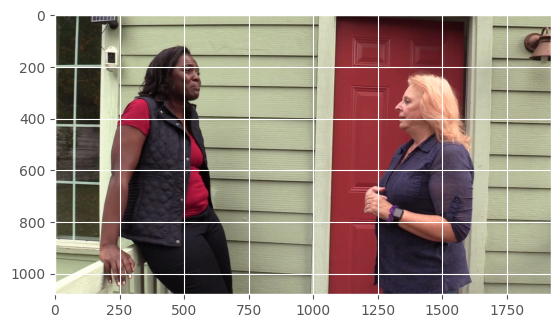

In [29]:
real = []
X_real = []
real = np.array([imageio.v2.imread(fname) for fname in real_image_names])
X_real = np.array([image.flatten() for image in real])
print(real.shape)
print(type(real))

plt.imshow(real[6])
print(X_real.shape)

In [30]:
PATH = 'kaggle/input/deepfake-detection-challenge/scratch-1/fake-image/' # the directory where all the output result are located.
fake_image_names = []
fake_image_names = get_list_filenames(PATH)
print(len(fake_image_names))

350


(350, 1080, 1920, 3)
<class 'numpy.ndarray'>
(350, 6220800)


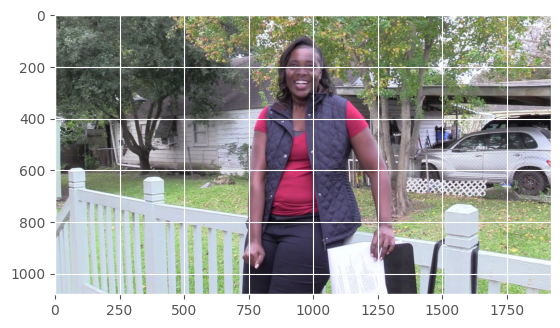

In [31]:
fake = []
X_fake = []
fake = np.array([imageio.v2.imread(fname) for fname in fake_image_names])
X_fake = np.array([image.flatten() for image in fake])
print(fake.shape)
print(type(fake))

plt.imshow(fake[6])
print(X_fake.shape)

In [32]:
train_test_data = []

In [33]:
for i in enumerate(X_real):
  train_test_data.append((X_real[i], "real"))
for i in enumerate(X_fake):
  train_test_data.append((X_fake[i], "fake"))

In [34]:
print(len(train_test_data))

700


In [35]:
train_test_data = np.array(train_test_data, dtype=object)
np.savez_compressed("kaggle/input/deepfake-detection-challenge/scratch-2/train_test_data/train_test_data_all.npz", train_test_data)

In [9]:
#train_test_data = np.load("kaggle/input/deepfake-detection-challenge/scratch-2/train_test_data/train_test_data_all.npz", allow_pickle=True)

In [36]:
print(len(train_test_data))

700


In [37]:
X = []
for i in train_test_data:
  X.append(i[0])
print(len(X))

700


In [38]:
y = []    
for i in train_test_data:    
  y.append(i[1])
print(len(y))

700


In [39]:
print(train_test_data.shape)

(700, 2)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True) 

In [82]:
svm_model = make_pipeline(StandardScaler(), SVC(gamma='scale', C = 1, probability=True)) 
svm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1, probability=True))])

In [83]:
svm_svc_filename = 'kaggle/input/deepfake-detection-challenge/scratch-2/model/svm_svc.pkl'
pickle.dump(svm_model, open(svm_svc_filename, 'wb'))

In [2]:
#svm_svc_filename = 'kaggle/input/deepfake-detection-challenge/scratch-2/model/svm_svc.pkl'
#svm_model = pickle.load(open(svm_svc_filename, 'rb'))

In [84]:
y_pred = svm_model.predict(X_test)

In [ ]:
#conf_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred)

In [ ]:
#svm_nusvc_model = make_pipeline(StandardScaler(), NuSVC(kernel='rbf')) 
#svm_nusvc_model.fit(X_train, y_train)

In [ ]:
#svm_nusvc_filename = 'kaggle/input/deepfake-detection-challenge/scratch-2/model/svm_nusvc.pkl'
#pickle.dump(svm_nusvc_model, open(svm_nusvc_filename, 'wb'))

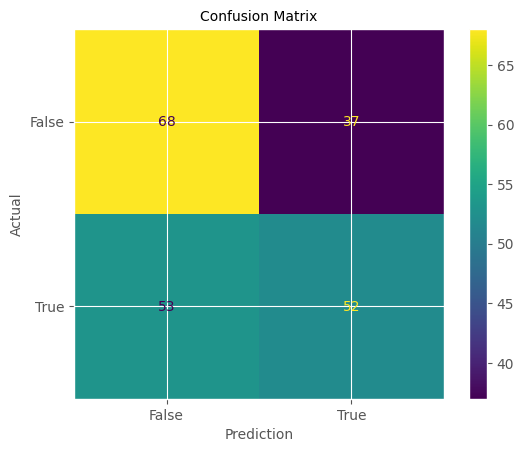

In [85]:
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
confusion_matrix_display.plot()
plt.xlabel('Prediction', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()

In [86]:
print("Accuracy Score : " + str(accuracy_score(y_test, y_pred)))

Accuracy Score : 0.5714285714285714


In [88]:
target_names = ['fake', 'real']
class_report = classification_report(y_test, y_pred, target_names=target_names)
print(class_report)

              precision    recall  f1-score   support

        fake       0.56      0.65      0.60       105
        real       0.58      0.50      0.54       105

    accuracy                           0.57       210
   macro avg       0.57      0.57      0.57       210
weighted avg       0.57      0.57      0.57       210



In [ ]:
y_proba = svm_model.predict_proba(X)

In [ ]:
scikitplot.metrics.plot_roc_curve(y_test, y_proba, cmap='nipy_spectral')
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
